<a href="https://colab.research.google.com/github/ElioRame/ProgrammingAssignment2/blob/master/PALS0039_Ex_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 4.1 Sentiment Analysis from text

In this exercise we implement a DNN system for [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) of movie reviews.

We use a set of film reviews taken from the [Internet Movie Database](https://www.imdb.com/) which have been labelled as positive or negative. Words in the reviews have already been tokenised and encoded as numbers using a dictionary. We load the numeric sequences as variable length lists then build a bag of words model for each review. This gives a fixed length vector for each review which we can input into a DNN classifier.

---
(a) Run the following code block which loads the pre-prepared dataset from the Keras package. Examine the Keras documentation for the [`load_data` method](https://keras.io/api/datasets/imdb/) and add a comment to explain the arguments used (including the defaults for `skip_top`, `start_char`, `oov_char`).

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import imdb

#(a)
# the IMDB dataset contains reviews for 25,000 movies labeled by sentiment; each review is encoded as a list of indexes (by frequency, i.e. index "3" is the third most frequent word in the data)
# num_words refers to the number of indexes to be kept (so starting from the top, that is the n number of most frequent words)
# index_from i.e. index_from=2 will give you indexes from 2 up
# path = from where to get the data
# skip_top = skip the n most frequently used words, they will appear as oov_char if skip_top is not set to zero. defaukts to zero
# maxlen = max len of the sequence
# seed = integer for reproducible shuffling
# oov_char are words cut out because of the num_words and skip_top limits, oov_char = integer that will represent the words, i.e. if = 2 then the oov_char will be indexed with n2
# start_char = the start of the sequence will be marked with this integer (defaults to 1)
(Xtrain_seq, ytrain), (Xtest_seq, ytest) = imdb.load_data(num_words=10000, index_from=2)

# Print out a sample (first few inputs and associated outputs) of the data
print("SAMPLE OF THE DATA:")
print("-------------------")
print("INPUTS:")
print(Xtrain_seq[:10])
print("OUTPUTS:")
print(ytrain[:3])



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
SAMPLE OF THE DATA:
-------------------
INPUTS:
[list([1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11,

---
(b) Examine the sample inputs and outputs above. What do the rows of the inputs represent, what do the numbers in the input represent? What do the numbers in the output represent. Why do all the inputs start with the number 1?


In [23]:
#(b)
# rows of inputs represent sequences of words in the reviews, the number represents how frequent the word is
# the output represents whether the review has been labelled as positive or negative (1 or 0), i.e. here ytrain[:3] and we get the rating for the first three sequences
# imdb dataset uses 1 at the start of sequences (as per start_char in imdb.data documentation)

(c) How many out-of-vocabulary (OOV) terms occur in each of the first three documents examined above? Write a short piece of code to determine the lengths and number of OOVs in each:

In [24]:
#(c)
#ANSWER
for document in Xtrain_seq[:3]:
  print("number of words per sequence:", len(document))
  print("OOV:", document.count(2))

number of words per sequence: 218
OOV: 6
number of words per sequence: 189
OOV: 7
number of words per sequence: 141
OOV: 2


(d) Determine the highest term index occuring in our dataset?

In [25]:
#(d)
#ANSWER
highest_index_per_document = []
for i in Xtrain_seq:
  highest_index_per_document.append(max(i))

highest_term_index = max(highest_index_per_document)
print("Highest term:", highest_term_index)

Highest term: 9999


---
The following code retrieves the mapping terms -> indices (starting from 1) from the corpus and uses this to create an inverse mapping (indices -> terms) taking care to include the special symbols we have introduced with `load_data`.

In [26]:
term_to_index = imdb.get_word_index()

index_to_term = {0: "PAD", 1: "START", 2: "OOV"}
for term, index in term_to_index.items():
  index_to_term[index + 2] = term

# Print out the mappings to the special symbols and the top 10 most frequent words therafter
for i in range(13):
  print(i, index_to_term[i], sep="\t")


0	PAD
1	START
2	OOV
3	the
4	and
5	a
6	of
7	to
8	is
9	br
10	in
11	it
12	i


---
(e) Use the index -> term mapping created above to convert the first document to a human-readable version

In [27]:
#(e)
#ANSWER
first_document = Xtrain_seq[0]
for term_index in first_document:
  term = index_to_term[term_index]
  print(term, end = " ")

START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert OOV is an amazing actor and now the same being director OOV father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for OOV and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also OOV to the two little boy's that played the OOV of norman and paul they were just brilliant children are often left out of the OOV list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have do

---
We now vectorise the review documents. Run the code.

In [28]:
# Function to convert a list of documents into counts of term indices.
# Each row represents a single document and each column represents the counts of each term in the document.
def bags_of_words(documents, numterms=10000):
  # We create an empty array of the right size before we begin:
  document_term_counts = np.zeros((len(documents), numterms))
  # Now we loop over all documents and terms and count them:
  for document_index, document in enumerate(documents):
    for term_index in document:
      document_term_counts[document_index, term_index] += 1
  return document_term_counts

# Convert training and test data to fixed-length vectors
Xtrain = bags_of_words(Xtrain_seq)
Xtest = bags_of_words(Xtest_seq)

# Convert labels to numpy array
ytrain = np.array(ytrain)
ytest = np.array(ytest)

# Print out some of the data to see what it looks like
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)
print(Xtrain[:10])

(25000, 10000) (25000,) (25000, 10000) (25000,)
[[ 0.  1.  6. ...  0.  0.  0.]
 [ 0.  1.  7. ...  0.  0.  0.]
 [ 0.  1.  2. ...  0.  0.  0.]
 ...
 [ 0.  1. 37. ...  0.  0.  0.]
 [ 0.  1.  5. ...  0.  0.  0.]
 [ 0.  1.  2. ...  0.  0.  0.]]


---
Build the DNN model. Run the code and add comments.

In [29]:
def build_model(input_width=10000, hidden_width=16, output_width=1, add_hidden_layers=1, hidden_layer_activation="sigmoid"):
  model = Sequential()
  model.add(Dense(hidden_width, activation=hidden_layer_activation, input_shape=(input_width,)))
  for i in range(add_hidden_layers):
    model.add(Dense(hidden_width, activation=hidden_layer_activation))
  model.add(Dense(output_width, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
  return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

---
(f) Call the `model.fit` method with the correct arguments to train the model with the following specifications: (1) Train for 30 iterations over the dataset; (2) Update the weights during training in batches of 64 samples; (3) Request Keras to randomly select 10% of the training set as the **validation set**.

In [47]:
#(f)
training_info = model.fit(Xtrain, ytrain, epochs = 30, batch_size = 64, validation_split=0.10)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 8.8800e-06 - val_accuracy: 0.9348 - val_loss: 0.6959
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 9.0325e-06 - val_accuracy: 0.9352 - val_loss: 0.7013
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 8.6793e-06 - val_accuracy: 0.9352 - val_loss: 0.6986
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 8.5042e-06 - val_accuracy: 0.9348 - val_loss: 0.7011
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: 8.1334e-06 - val_accuracy: 0.9348 - val_loss: 0.7010
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 8.4075e-06 - val_accuracy: 0.9348 - val_loss: 0.7039
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 8.5091e-06 - val_accuracy: 0.9344 - val_loss: 0.7037
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - lo

---
Plot and examine the training graphs, compare the training and evaluation errors. Run the code.

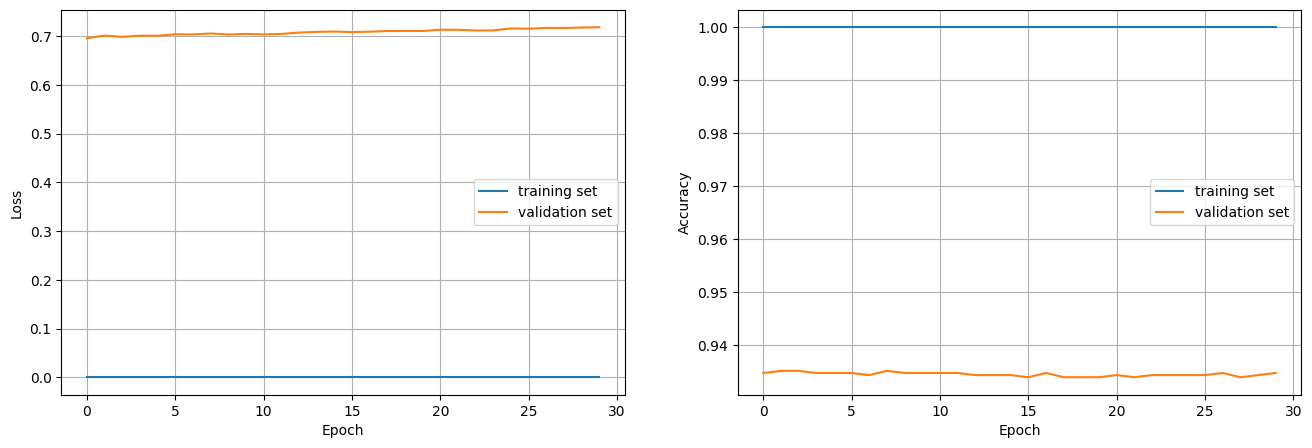

In [48]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['accuracy'], label="training set")
    axs[1].plot(training_info.history['val_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

(g) Does the process exhibit overfitting or underfitting? Is the performance of the classifier good? Is 30 epochs a reasonable choice? Should the number of epochs be increased or decreased?

In [44]:
#(g)
#overfitting
#epochs should be decreased (keras.callback), validation set should approximately have 50% of each output

The follow applies TF-IDF transform to the term counts and repeats the model training experiment

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5128 - loss: 0.7033 - val_accuracy: 0.5124 - val_loss: 0.6889
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5783 - loss: 0.6878 - val_accuracy: 0.7496 - val_loss: 0.6812
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6917 - loss: 0.6770 - val_accuracy: 0.6024 - val_loss: 0.6622
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7503 - loss: 0.6513 - val_accuracy: 0.7532 - val_loss: 0.6155
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7931 - loss: 0.5904 - val_accuracy: 0.8224 - val_loss: 0.5195
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8344 - loss: 0.4841 - val_accuracy: 0.8532 - val_loss: 0.4093
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8683 - loss: 0.3729 - val_accuracy: 0.8692 - val_loss: 0.3382
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8871 - loss: 0.3004 - val_accuracy: 0.

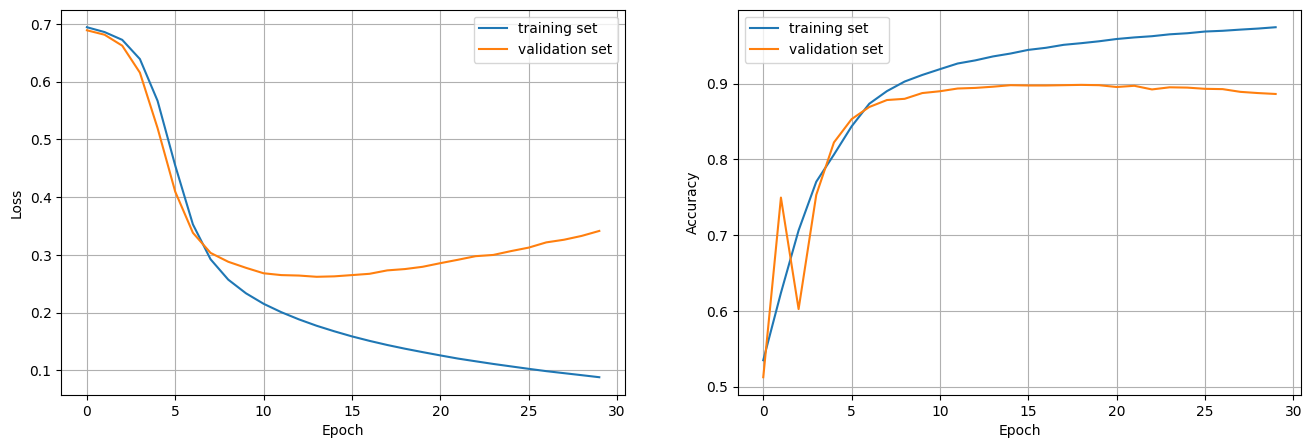

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(Xtrain)
Xtrain_tfidf = tfidf_transformer.transform(Xtrain).toarray()

model_tfidf = build_model()
training_info = model_tfidf.fit(Xtrain_tfidf, ytrain, epochs=30, batch_size=64, validation_split=0.10)
plot_training_history(training_info)

---
(h) Does the TF-IDF transform improve the model performance with current choice of parameters? Can you think of possible reasons?

In [50]:
#(h)
#yes
#normalisation
#on the other hand the emotional valence of the reviews might actually be tied to the relative frequency of specific words compared to others

---
(i) Estimate the generalisation performance of the two models on the test set (use the [`model.evaluate` method](https://keras.io/api/models/model_training_apis/#evaluate-method)). How does the test accuracy compare to those on the validation set? Why?

In [51]:
#(i)
#ANSWER
models_data = {"Initial model": (model, Xtest), "TF-IDF model": (model_tfidf, tfidf_transformer.transform(Xtest).toarray())}
for this_label, (this_model, this_Xtest) in models_data.items():
  test_loss, test_accuracy = this_model.evaluate(this_Xtest, ytest, verbose=0)
  print(this_label,)
  print("Test loss:", test_loss)
  print("Test accuracy:", test_accuracy)
  print("-----------------------------------------")

Initial model
Test loss: 1.5375646352767944
Test accuracy: 0.8504400253295898
-----------------------------------------
TF-IDF model
Test loss: 0.36926108598709106
Test accuracy: 0.8704000115394592
-----------------------------------------


---
(j) Inspect the predictions of the first model on the first 10 documents in the test set (use the model.predict method). Also convert the test documents to human-readable format as before. Do the predictions seem sensible?

In [52]:
#(j)
#ANSWER
print(model.predict(Xtest[:10]))

for document in Xtest_seq[:10]:
  print()
  for term_index in document:
    term = index_to_term[term_index]
    print(term, end=" ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[[5.0499645e-04]
 [1.0000000e+00]
 [9.9950141e-01]
 [9.9999905e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999809e-01]
 [2.2762385e-09]
 [1.0000000e+00]
 [1.0000000e+00]]

START please give this one a miss br br OOV OOV and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite OOV so all you madison fans give this a miss 
START this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances OOV the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere OOV with sexual tension and psychological OOV it's very interesting that robert altman directed this considering the style and structure of 

---
(k) **Optional:** Experiment with the problem to try to improve performance, e.g. by changing the the structure of the network: size, number of layers, optimizer, learning rate, number of epochs.
